In [1]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt

%matplotlib inline
from google.colab import drive
from collections import Counter
from gensim.models import word2vec

import pickle5 as pickle

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, Flatten, Multiply
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.vis_utils import plot_model

import nltk 
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')
STOP_WORDS = nltk.corpus.stopwords.words()

# Mount drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! unzip '/content/drive/MyDrive/NLP/pickle_files.zip'

Archive:  /content/drive/MyDrive/NLP/pickle_files.zip
replace countvec.pickle? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glovewordembeddings.pickle? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tfidf.pickle? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
def tokenize(s):
    tokens = []
    tokens = [word_tokenize(str(sentence)) for sentence in s]

    token = []
    for word in tokens:
        sm = re.sub('[^A-Za-z]',' ', str(word))
        x = re.split("\s", sm)
        token.append(x)
        
    return token

In [5]:
def lower_case(sentence):
    for sent in sentence:
        while '' in sent:
            sent.remove('')
            
    low = []
    for i in sentence:
        i = [x.lower() for x in i]
        low.append(i)
        
    return low

In [6]:
def lemmatize(s):
    lemma = []
    word_net = WordNetLemmatizer()
    for doc in s:
        tokens = [word_net.lemmatize(w) for w in doc]
        lemma.append(tokens)

    filter_words = []
    Stopwords = set(stopwords.words('english'))

    for sent in lemma:
        tokens = [w for w in sent if w not in Stopwords]
        filter_words.append(tokens)

    space = ' ' 
    sentences = []
    for sentence in filter_words:
        sentences.append(space.join(sentence))
        
    return sentences

In [7]:
df = pd.read_csv('/content/drive/MyDrive/NLP/train.csv')

In [8]:
test_data = pd.read_csv('/content/drive/MyDrive/NLP/test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
MAX_NB_WORDS = 200000
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(list(df['question1'].values.astype(str))+list(df['question2'].values.astype(str)))

In [10]:
X_train_q1 = tokenizer.texts_to_sequences(df['question1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding='post')

X_train_q2 = tokenizer.texts_to_sequences(df['question2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding='post')

In [11]:
X_valid_q1 = test_data.iloc[:400001,1:2].values
X_valid_q2 = test_data.iloc[:400001, 2:].values

In [12]:
X_train = df.iloc[:,:5].values
Y_train = df.iloc[:,5:].values

In [13]:
X_valid_q1 = tokenizer.texts_to_sequences(X_valid_q1.ravel())
X_valid_q1 = pad_sequences(X_valid_q1,maxlen = 30, padding='post')

X_valid_q2 = tokenizer.texts_to_sequences(X_valid_q2.astype(str).ravel())
X_valid_q2 = pad_sequences(X_valid_q2, maxlen = 30, padding='post')

In [14]:
y = df['is_duplicate']

In [25]:
X_train_q1,X_valid_q1, X_train_q2, X_valid_q2, y_train, y_valid = train_test_split(X_train_q1, X_train_q2, y, test_size=0.20, random_state=12)

In [16]:
embedding_index = {}
with open('/content/drive/MyDrive/NLP/AssignmentThree/glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_index[word] = vectors
    f.close()

In [17]:
word_index = tokenizer.word_index

In [18]:
embedding_matrix = np.random.random((len(word_index)+1, 200))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
# Model for Q1
model_q1 = tf.keras.Sequential()
model_q1.add(Embedding(input_dim = len(word_index)+1,
                       output_dim = 200,
                      weights = [embedding_matrix],
                      input_length = 30))
model_q1.add(LSTM(128, activation = 'tanh', return_sequences = True))
model_q1.add(Dropout(0.2))
model_q1.add(LSTM(128, return_sequences = True))
model_q1.add(LSTM(128))
model_q1.add(Dense(60, activation = 'tanh'))
model_q1.add(Dense(2, activation = 'sigmoid'))

In [20]:
# Model for Q2
model_q2 = tf.keras.Sequential()
model_q2.add(Embedding(input_dim = len(word_index)+1,
                       output_dim = 200,
                      weights = [embedding_matrix],
                      input_length = 30))
model_q2.add(LSTM(128, activation = 'tanh', return_sequences = True))
model_q2.add(Dropout(0.2))
model_q2.add(LSTM(128, return_sequences = True))
model_q2.add(LSTM(128))
model_q2.add(Dense(60, activation = 'tanh'))
model_q2.add(Dense(2, activation = 'sigmoid'))

In [21]:
combined_model = Multiply()([model_q1.output, model_q2.output])

combined_model = Flatten()(combined_model)
combined_model = Dense(100, activation = 'relu')(combined_model)
combined_model = Dropout(0.2)(combined_model)
combined_model = Dense(50, activation = 'relu')(combined_model)
combined_model = Dropout(0.2)(combined_model)
combined_model = Dense(2, activation = 'sigmoid')(combined_model)

In [27]:
final_model = Model([model_q1.input, model_q2.input], combined_model)
final_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
history = final_model.fit([X_train_q1,X_train_q2],y_train, batch_size = 2000, epochs = 10, validation_data = ([X_valid_q1,X_valid_q2],y_valid))

Epoch 1/10
162/162 [==============================] - 41s 165ms/step - loss: 0.6450 - accuracy: 0.6315 - val_loss: 0.5947 - val_accuracy: 0.6901
Epoch 2/10
162/162 [==============================] - 25s 155ms/step - loss: 0.5487 - accuracy: 0.7254 - val_loss: 0.5214 - val_accuracy: 0.7465
Epoch 3/10
162/162 [==============================] - 26s 158ms/step - loss: 0.4993 - accuracy: 0.7578 - val_loss: 0.5019 - val_accuracy: 0.7579
Epoch 4/10
162/162 [==============================] - 26s 159ms/step - loss: 0.4652 - accuracy: 0.7779 - val_loss: 0.4942 - val_accuracy: 0.7632
Epoch 5/10
162/162 [==============================] - 26s 160ms/step - loss: 0.4338 - accuracy: 0.7947 - val_loss: 0.4921 - val_accuracy: 0.7668
Epoch 6/10
162/162 [==============================] - 26s 162ms/step - loss: 0.4039 - accuracy: 0.8105 - val_loss: 0.5072 - val_accuracy: 0.7699
Epoch 7/10
162/162 [==============================] - 26s 163ms/step - loss: 0.3752 - accuracy: 0.8256 - val_loss: 0.5181 - val_ac

In [28]:
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 30)]         0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 30)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 200)      19119400    ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 30, 200)      19119400    ['embedding_1_input[0][0]']      
                                                                                            

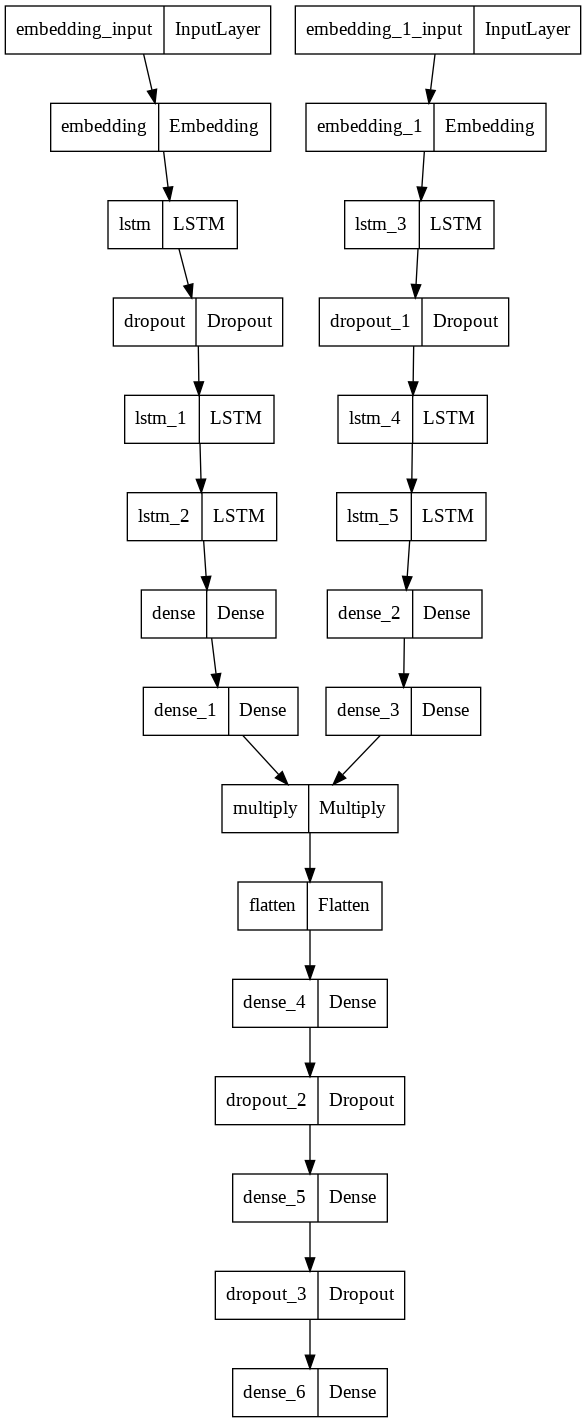

In [29]:
plot_model(final_model, to_file = 'model.png')

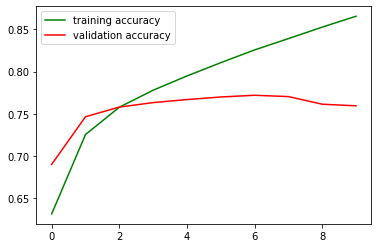

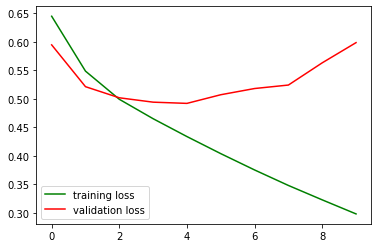

In [30]:
accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

#plot 
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()